In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import hmean, norm
from nltk import word_tokenize
from collections import Counter
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import numpy as np
from statistics import harmonic_mean

In [30]:
#data= load_dataset("imdb", split= "test")
#data= load_dataset("oscar", "unshuffled_deduplicated_en", split = "train", streaming= True)
#data= load_dataset("poem_sentiment","plain_text", split = "test")
data = load_dataset("bible_para", "en-fr",split="train")
#data_head = data.take(10)

Reusing dataset bible_para (/home/sasha/.cache/huggingface/datasets/bible_para/en-fr/1.0.0/b6cc20bcbfb0299beeba1dcc80a8420b975938ca0eef75b3ed30b50df7d950b1)


In [22]:
def count_vocab_frequencies(dataframe, col):
    """
    Based on an input pandas DataFrame with a 'text' column, 
    this function will count the occurrences of ALL words 
    (no stop word removal) and will return another DataFrame
    with the rows corresponding to the different vocabulary words
    and the column to the total count of that word.
    """
    cvec = CountVectorizer(token_pattern=u"(?u)\\b\\w+\\b")
    #needed to modify the minimum token length : https://stackoverflow.com/questions/33260505/countvectorizer-ignoring-i
    cvec.fit(dataframe[col])
    document_matrix = cvec.transform(dataframe[col])
    batches = np.linspace(0,dataframe.shape[0],100).astype(int)
    i=0
    tf = []
    while i < len(batches)-1:
        batch_result = np.sum(document_matrix[batches[i]:batches[i+1]].toarray(),axis=0)
        tf.append(batch_result)
        i += 1
    term_freq_df = pd.DataFrame([np.sum(tf,axis=0)],columns=cvec.get_feature_names()).transpose()
    term_freq_df.columns=['total']
    return(term_freq_df)

In [25]:
def Zipf_plot(dataframe):
    """
    This function plots the correspondence of the distribution of terms
    generated by count_vocab_frequencies with the projected Zipf's law
    distribution.
    s is the value of the exponent characterizing the distribution, currently at 1.
    # TODO : see if changing this makes the distribution fit better -- 
    e.g. When Zipf's law is checked for cities, a better fit has been found with exponent s = 1.07
    """
    y_pos = np.arange(500)
    plt.figure(figsize=(10,8))
    s = 1
    expected_zipf = [dataframe.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
    plt.bar(y_pos, dataframe.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
    plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
    plt.ylabel('Frequency')
    plt.title("Top 500 tokens in the dataset, with Zipf's law in dotted red")

In [27]:
def Zipf_check_words(dataframe, num_words):
    """
    Checks the Zipf's law of the top [num_words] most frequent words in dataframe.
    Returns a dataframe with 3 columns:
    total = the raw number of counts 
    zipf = the projected counts according to Zipf
    difference = the *percentage* difference between the two
    """
    s = 1
    terms = pd.DataFrame(dataframe.sort_values(by='total', ascending=False)['total'][:num_words])
    expected_zipf=[dataframe.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in np.arange(num_words)]
    terms['zipf'] = [int(z) for z in expected_zipf]
    terms['difference'] = terms.apply(lambda x: ((x['total']- x['zipf'])/x['zipf']* 100), axis=1)
    return(terms)

In [54]:
def check_open_class(dataframe, threshold, closedlist):
    closedclass= dataframe[dataframe.index.isin(closedlist)]
    openclass= dataframe[~dataframe.index.isin(closedlist)]
    openclassthreshold= openclass.loc[(openclass['difference'] >=threshold)]
    print("There are: "+ str(openclassthreshold.shape[0])+ " closed class words that are above the %s threshold" %(threshold))
    return(openclassthreshold.sort_values(by='difference', ascending=False))

In [44]:
def check_closed_class(dataframe, threshold, closedlist):
    '''
    Based on a dataframe and a threshold, checks how many closed-class 
    words are above the threshold, and returns the dataframe sorted by 
    difference.
    '''
    closedclass= dataframe[dataframe.index.isin(closedlist)]
    closedclassthreshold= closedclass.loc[(closedclass['difference'] >=threshold)]
    print("There are: "+ str(closedclassthreshold.shape[0])+ " closed class words that are above the %s threshold" %(threshold))
    return(closedclassthreshold.sort_values(by='difference', ascending=False))

In [46]:
#Creating the closed word list from the txt file
en_wordlist=open('../resources/closed_EN.txt', 'r').readlines()
en_closedlist=[]
for l in en_wordlist:
    en_closedlist= en_closedlist + (l.split())
print("There are: "+ str(len(en_closedlist)) + " closed-class words in English.")

There are: 312 closed-class words in English.


In [48]:
#Creating the closed word list from the txt file
fr_wordlist=open('../resources/closed-class.fr.txt', 'r').readlines()
fr_closedlist=[]
for l in fr_wordlist:
    fr_closedlist= fr_closedlist + (l.split())
print("There are: "+ str(len(fr_closedlist)) + " closed-class words in French.")

There are: 783 closed-class words in French.


In [ ]:
#For streaming data
data_head = data.take(10000)
datadf= pd.DataFrame(data_head)

In [32]:
#for non-streaming data
datadf = pd.json_normalize(data)

#### Looking at the top rows

In [33]:
datadf.head()

,id,translation.en,translation.fr
0,0,In the beginning God created the heavens and t...,"Au commencement, Dieu créa les cieux et la terre."
1,1,Now the earth was formless and empty. Darkness...,La terre était informe et vide: il y avait des...
2,2,"God said, ""Let there be light,"" and there was ...",Dieu dit: Que la lumière soit! Et la lumière fut.
3,3,"God saw the light, and saw that it was good. G...",Dieu vit que la lumière était bonne; et Dieu s...
4,4,"God called the light ""day,"" and the darkness h...","Dieu appela la lumière jour, et il appela les ..."


#### Getting more information

In [59]:
datadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62195 entries, 0 to 62194
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              62195 non-null  object
 1   translation.en  62195 non-null  object
 2   translation.fr  62195 non-null  object
dtypes: object(3)
memory usage: 1.4+ MB


#### Checking for missing values

In [14]:
datadf[datadf.isnull().any(axis=1)].head()

,id,translation.fr,translation.ru


In [15]:
np.sum(datadf.isnull().any(axis=1))

0

#### Count vocab size + frequencies

In [34]:
term_df= count_vocab_frequencies(datadf,'translation.en')

In [36]:
term_df_fr= count_vocab_frequencies(datadf,'translation.fr')

#### Zipf's law plot

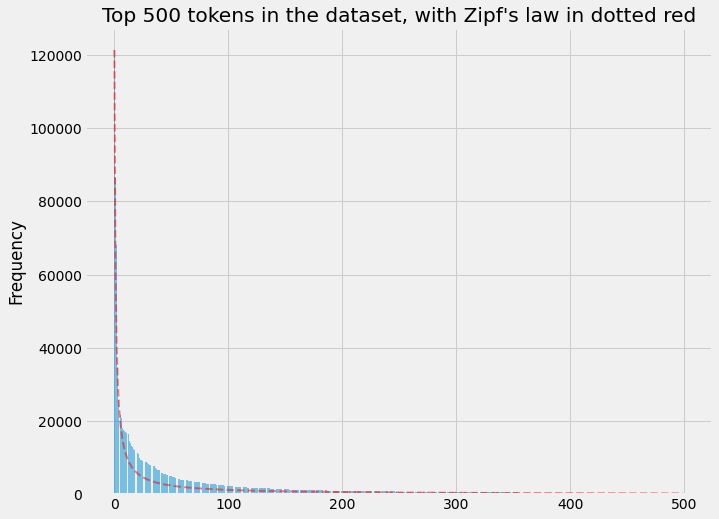

In [35]:
Zipf_plot(term_df)

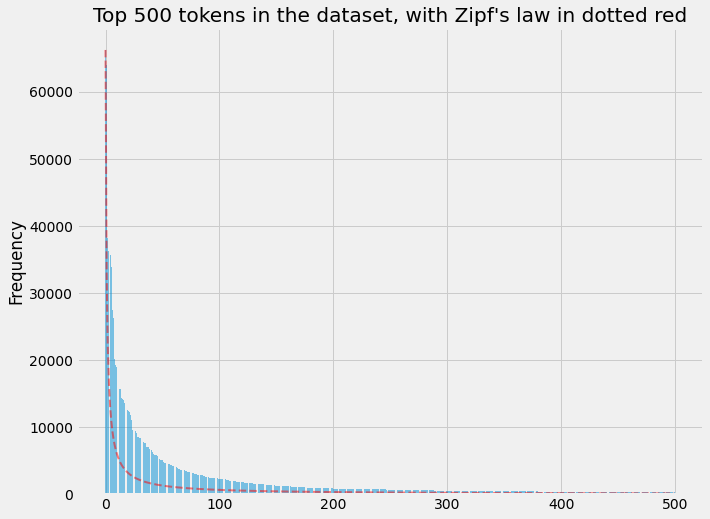

In [37]:
Zipf_plot(term_df_fr)

### Checking which words do not respect Zipf's law

In [38]:
zipf_df= Zipf_check_words(term_df,500)

In [39]:
zipf_df.loc[(zipf_df['difference'] >=100)].head(10)

,total,zipf,difference
unto,8999,4495,100.200222
was,8827,4335,103.621684
have,8730,4185,108.602151
god,8586,4046,112.209590
me,8175,3915,108.812261
but,7951,3793,109.622990
their,7938,3678,115.823817
said,7925,3570,121.988796
from,7829,3468,125.749712
which,7653,3371,127.024622


In [40]:
zipf_df_fr= Zipf_check_words(term_df_fr,500)

In [41]:
zipf_df_fr.loc[(zipf_df_fr['difference'] >=100)].head(10)

,total,zipf,difference
l,36275,16547,119.224029
le,35632,13237,169.184861
les,33810,11031,206.499864
à,27432,9455,190.132205
il,26238,8273,217.152182
qui,20214,7354,174.870819
des,19231,6618,190.586280
d,18977,6017,215.389729
que,18229,5515,230.534905
est,15644,5091,207.287370


### Checking open versus closed class words

In [50]:
check_closed_class(zipf_df,100,en_closedlist)

There are: 28 closed class words that are above the 100 threshold


,total,zipf,difference
which,7653,3371,127.024622
from,7829,3468,125.749712
on,6706,3034,121.028345
are,6510,2960,119.932432
who,7191,3280,119.237805
as,6750,3112,116.902314
their,7938,3678,115.823817
but,7951,3793,109.622990
me,8175,3915,108.812261
have,8730,4185,108.602151


In [57]:
check_closed_class(zipf_df_fr,100,fr_closedlist)

There are: 145 closed class words that are above the 100 threshold


,total,zipf,difference
une,7615,1838,314.309032
nous,7008,1697,312.964054
du,11816,2877,310.705596
leur,5778,1408,310.369318
ils,12240,3008,306.914894
...,...,...,...
quoi,336,150,124.000000
avais,318,142,123.943662
eu,294,133,121.052632
celle,296,134,120.895522


In [55]:
check_open_class(zipf_df,100,en_closedlist)

There are: 21 closed class words that are above the 100 threshold


,total,zipf,difference
said,7925,3570,121.988796
yahweh,6840,3194,114.151534
god,8586,4046,112.209590
king,5086,2427,109.559126
man,5104,2477,106.055713
went,2774,1348,105.786350
thy,4602,2247,104.806409
son,4778,2334,104.712939
israel,5157,2528,103.995253
came,3802,1867,103.642207


In [58]:
check_open_class(zipf_df_fr,100,fr_closedlist)

There are: 352 closed class words that are above the 100 threshold


,total,zipf,difference
s,6572,1614,307.187113
comme,5850,1438,306.815021
fils,8341,2068,303.336557
se,7740,1946,297.738952
car,6230,1575,295.555556
...,...,...,...
samuel,294,134,119.402985
aucune,296,135,119.259259
assignation,296,135,119.259259
l,36275,16547,119.224029


In [ ]:
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, RegexpTokenizer

In [68]:
en_alllist=[sent for sent in datadf['translation.en']]
corp= ' '. join(s for s in en_alllist)
tokenizer = RegexpTokenizer(r"\w+")
vocab = FreqDist(word.lower() for word in tokenizer.tokenize(corp))
print("There are " + str(len(vocab)) + " words including stop words in English")

There are 15894 words including stop words in English


In [69]:
fr_alllist=[sent for sent in datadf['translation.fr']]
corp= ' '. join(s for s in fr_alllist)
tokenizer = RegexpTokenizer(r"\w+")
vocab = FreqDist(word.lower() for word in tokenizer.tokenize(corp))
print("There are " + str(len(vocab)) + " words including stop words in French")

There are 20532 words including stop words in French


In [71]:
import statistics

In [76]:
total_lens = 0
alllengths=[]
for i, sent in enumerate(en_alllist):
    lent=len(tokenizer.tokenize(sent))
    alllengths.append(lent)
    total_lens += lent
avg_sent_len = total_lens / i
print("The average English sentence length is: " + str(round(avg_sent_len,4)) + " words.")
print("The mean sentence English length is: " + str(statistics.mean(alllengths)) + " words.")
print("The median sentence English length is: " + str(statistics.median(alllengths)) + " words.")

The average English sentence length is: 25.0684 words.
The mean sentence English length is: 25.068027976525443 words.
The median sentence English length is: 23 words.


In [78]:
total_lens = 0
alllengths=[]
for i, sent in enumerate(fr_alllist):
    lent=len(tokenizer.tokenize(sent))
    alllengths.append(lent)
    total_lens += lent
avg_sent_len = total_lens / i
print("The average French sentence length is: " + str(round(avg_sent_len,4)) + " words.")
print("The mean sentence French length is: " + str(statistics.mean(alllengths)) + " words.")
print("The median sentence French length is: " + str(statistics.median(alllengths)) + " words.")

The average French sentence length is: 25.171 words.
The mean sentence French length is: 25.170576412894928 words.
The median sentence French length is: 23 words.
